In [9]:
import sys
import os

sys.path.append("..")

from s4.dts4 import DecisionS4
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)
device = 'cpu'

device: mps


In [11]:
from envs.random_walk import RandomWalkEnv
from data.random_walk_dataset import RandomWalkDataset
from algorithms.sequence_models.evaluate import evaluate_on_env

In [12]:
from typing import Tuple
from dataclasses import dataclass

@dataclass
class TrainConfig:
	max_eval_ep_len: int      # max len of one evaluation episode
	context_len: int         # K in decision transformer
	rtg_range_check: Tuple[float, float]
	rtg_main: float
	
	num_eval_ep: int = 10          # num of evaluation episodes per iteration	
	batch_size: int = 64             # training batch size
	lr: float = 1e-3                   # learning rate
	wt_decay: float = 1e-4             # weight decay
	warmup_steps: int = 10000        # warmup steps for lr scheduler
	
	# total updates = max_train_iters x num_updates_per_iter
	max_train_iters: int = 200
	num_updates_per_iter: int = 100

	# GPT config	
	n_blocks: int = 3            # num of transformer blocks
	embed_dim: int = 128         # embedding (hidden) dim of transformer
	n_heads: int = 1             # num of transformer heads
	dropout_p: float = 0.1         # dropout probability


def train(model, optimizer, loss_fn, traj_dataset, config: TrainConfig, callbacks=[]):
	
	dataset = LimitedContextWrapper(traj_dataset, context_len=config.context_len)
	traj_data_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
	data_iter = iter(traj_data_loader)
		
	logger.start(iterations=config.max_train_iters, update_per_iter=config.num_updates_per_iter)

	log_action_losses_all = []
	
	for i_train_iter in range(config.max_train_iters):
		log_action_losses = []
		model.train()
	 
		for _ in range(config.num_updates_per_iter):
			try:
				timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
			except StopIteration:
				data_iter = iter(traj_data_loader)
				timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
	
			timesteps = timesteps.to(device)	# B x T
			states = states.to(device)			# B x T x state_dim
			actions = actions.to(device)		# B x T x act_dim
			returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
			traj_mask = traj_mask.to(device)	# B x T
	
			action_target = torch.clone(actions).detach().to(device)
		
			state_preds, action_preds, return_preds = model.forward(
															timesteps=timesteps,
															states=states,
															actions=actions,
															returns_to_go=returns_to_go
														)
			# only consider non padded elements
			act_dim = action_preds.shape[-1]
			action_preds = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
			action_target = action_target.view(-1, act_dim)[traj_mask.view(-1,) > 0]
	
			action_loss = loss_fn(action_preds, action_target)
	
			optimizer.zero_grad()
			action_loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
			optimizer.step()
			scheduler.step()
			
			log_action_losses.append(action_loss.detach().cpu().item())
			log_action_losses_all.append(log_action_losses[-1])
	
		for callback in callbacks:
			callback(loss=np.mean(log_action_losses))

	plt.plot(log_action_losses_all)
	plt.show()

In [13]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, loss, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=loss,
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_ep_len'] for res in self.eval_results[n//2:]])

collecting trajectories:   0%|          | 0/500 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-114, max=9 mean=-26.55295138888889
state_mean: [0.21267361 0.10047743 0.09939236 0.09895833 0.09787326 0.09635417
 0.09852431 0.1000434  0.09570312 0.        ]
state_std: [0.40919866 0.30063552 0.2991881  0.29860606 0.29714321 0.29507633
 0.29802226 0.30005786 0.29418368 0.        ]
gamma: 1


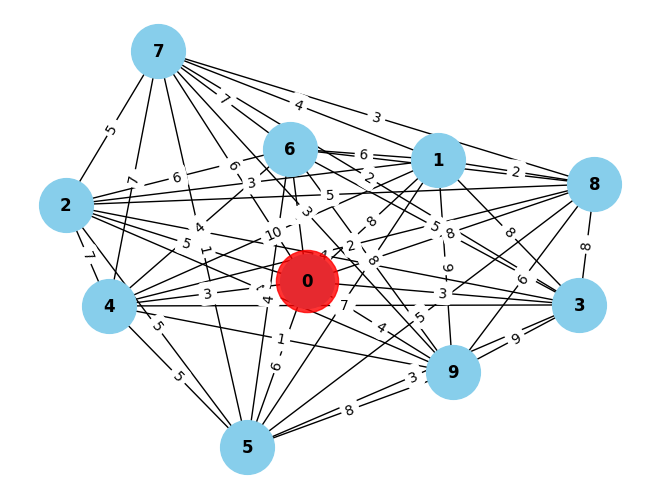

In [14]:
env = RandomWalkEnv(num_nodes=10, weight_max=10, reach_the_goal_reward=10, max_episode_length=20)
config = TrainConfig(max_eval_ep_len=20, context_len=25, rtg_range_check=(-10, 10), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=500, reward_scale=20)

env.reset()
env.render()

In [15]:
import datetime
from settings import LOG_DIR
from data.trajectory import LimitedContextWrapper
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import csv

class Logger:
	def __init__(self, name):
		self.name = name
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = 0
		self.previous_csv_extra_keys = None
		
		self.log_dir = os.path.join(LOG_DIR, "dt_runs")
		
		self.save_model_path = ""
		self.save_best_model_path = ""

		if not os.path.exists(self.log_dir):
			os.makedirs(self.log_dir)
		
		self.csv_writer = None
		self.pbar = None		
		self.is_started = False

	def start(self, iterations, update_per_iter):		
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = update_per_iter
		self.previous_csv_extra_keys = None
		
		prefix = "dt_"
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")
		save_model_name = prefix + self.name + "_model_" + start_time_str + ".pt"
		self.save_model_path = os.path.join(self.log_dir, save_model_name)
		self.save_best_model_path = self.save_model_path[:-3] + "_best.pt"
		log_csv_name = prefix + "_log_" + start_time_str + ".csv"
		log_csv_path = os.path.join(self.log_dir, log_csv_name)
		self.csv_writer = csv.writer(open(log_csv_path, 'a', 1))
		
		self.pbar = None		
		self.is_started = True
		self.pbar = tqdm(total=iterations)

	def finish(self):
		print("=" * 60)
		print("finished training!")
		print("=" * 60)
		end_time = datetime.datetime.now().replace(microsecond=0)
		time_elapsed = str(end_time - self.start_time)
		end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
		
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")

		print("started training at: " + start_time_str)
		print("finished training at: " + end_time_str)
		print("total training time: " + time_elapsed)
		print("best score: " + format(self.best_score, ".5f"))
		print("saved max d4rl score model at: " + self.save_best_model_path)
		print("saved last updated model at: " + self.save_model_path)
		print("=" * 60)

		self.is_started = False
		self.csv_writer.close()

	# todo later make it generic so that we can log whatever
	def log(self, model, loss, eval_avg_reward, important=set(), **kwargs):		
		if not self.is_started:
			raise Exception("call .start() first")

		if self.previous_csv_extra_keys is None:
			self.previous_csv_extra_keys = list(kwargs.keys())
			csv_header = (["duration", "num_updates", "action_loss", "eval_avg_reward", "best_score", *kwargs.keys()])
			self.csv_writer.writerow(csv_header)
		elif set(self.previous_csv_extra_keys) != set(kwargs.keys()):
			raise Exception(f"expected {set(self.previous_csv_extra_keys)} keys but passed {set(kwargs.keys())}. Maybe call finish?")
		
		self.iters += 1
		time_elapsed = str(datetime.datetime.now().replace(microsecond=0) - self.start_time)
		total_updates = self.iters * self.num_updates_per_iter
				
		log_str = '\n'.join([
			"=" * 60,
			"time elapsed: " + time_elapsed,
			"num of updates: " + str(total_updates),
			"loss: " +  format(loss, ".5f"),
			"eval avg reward: " + format(eval_avg_reward, ".5f"),
			"best score: " + format(self.best_score, ".5f"),
			*[key + " " + format(value, ".5f") for key, value in kwargs.items()]
		])

		log_data = [time_elapsed, total_updates, loss,
					eval_avg_reward, self.best_score] + [kwargs[key] for key in self.previous_csv_extra_keys]
		self.csv_writer.writerow(log_data)
		if eval_avg_reward >= self.best_score:
			print('achieved average reward: ', eval_avg_reward)
			print("saving max score model at: " + self.save_best_model_path)

			torch.save(model.state_dict(), self.save_best_model_path)
			self.best_score = eval_avg_reward
	
		print("saving current model at: " + self.save_model_path)
		torch.save(model.state_dict(), self.save_model_path)
		

		self.pbar.set_description(' '.join([
			f'Loss={loss}',
			f'Best_Score={self.best_score}',
			*[f'{key}={value:.5f}' for key, value in kwargs.items() if key in important]
		]))
		
		self.pbar.update(1)
		
		print(log_str)

In [16]:
logger = Logger(name='random-walk')
model = DecisionS4(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    h_dim=config.embed_dim,
    context_len=config.context_len,
    drop_p=config.dropout_p,
).to('cpu')

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)


callback = CustomCallback(env=env, model=model, optimizer=optimizer, logger=logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

print("number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train(model=model, optimizer=optimizer,
	  loss_fn=nn.MSELoss(reduction='mean'),
	  traj_dataset=traj_dataset, config=config,
	  callbacks=[callback.callback])

number of parameters: 596373


  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -42.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_random-walk_model_24-05-10-06-47-10_best.pt
saving current model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_random-walk_model_24-05-10-06-47-10.pt
time elapsed: 0:00:06
num of updates: 100
loss: 0.12728
eval avg reward: -42.00000
best score: -inf
eval_avg_ep_len 12.00000
grad_norm 0.12368
lr 0.00001
achieved average reward:  -10.0
saving max score model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_random-walk_model_24-05-10-06-47-10_best.pt
saving current model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt_random-walk_model_24-05-10-06-47-10.pt
time elapsed: 0:00:14
num of updates: 200
loss: 0.11619
eval avg reward: -10.00000
best score: -42.00000
eval_avg_ep_len 7.00000
grad_norm 0.08358
lr 0.00002
saving current model at: /Users/kaustubhdighe/Documents/MIT/6.8200/project/logs/dt_runs/dt

/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../s4/s4.py:155: SyntaxWarning: invalid escape sequence '\s'
  """
/Users/kaustubhdighe/Documents/MIT/6.8200/project/experiment_notebooks/../s4/s4.py:167: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

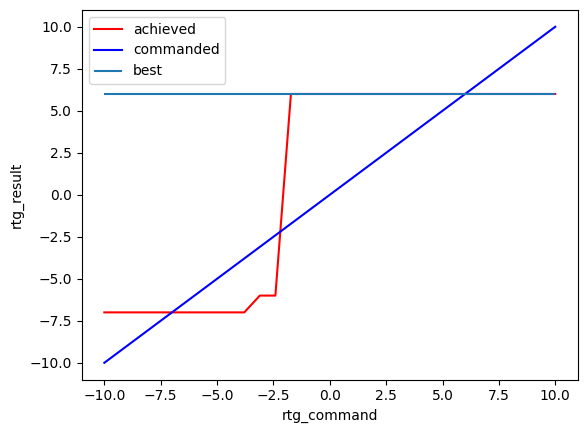

In [17]:
rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


import networkx as nx

shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))

plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])

plt.legend(["achieved", "commanded", "best"])


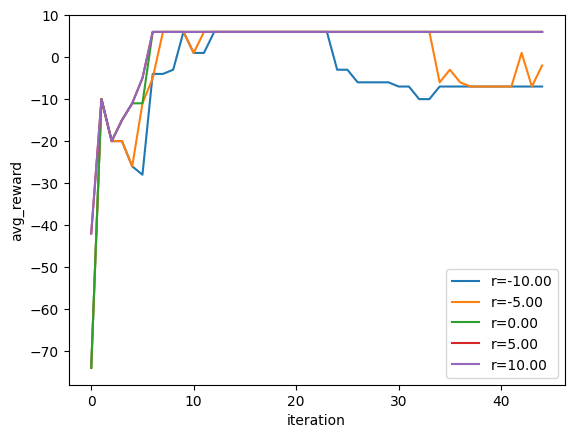

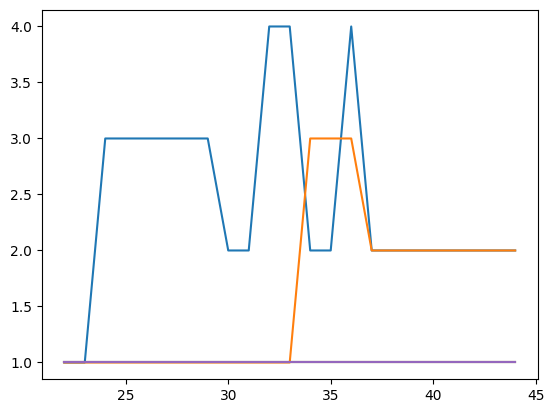

In [18]:
callback.plot_eval_results()